**Instantiating a small convnet**

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

  *Displaying the model's summary*

In [4]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0     

**Training the convnet on MNIST images**

In [5]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/5
938/938 [==============================] - 38s 8ms/step - loss: 0.1554 - accuracy: 0.9525
Epoch 2/5
938/938 [==============================] - 7s 8ms/step - loss: 0.0444 - accuracy: 0.9863
Epoch 3/5
938/938 [==============================] - 7s 8ms/step - loss: 0.0294 - accuracy: 0.9915
Epoch 4/5
938/938 [==============================] - 7s 8ms/step - loss: 0.0220 - accuracy: 0.9932
Epoch 5/5
938/938 [==============================] - 7s 8ms/step - loss: 0.0172 - accuracy: 0.9943


**Evaluating the convnet**

In [6]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 0.0356 - accuracy: 0.9901
Test accuracy: 0.990


Here we have trained a basic convnet on the mnist dataset and we can see that the accuracy if this model on test set is 99%. This makes ConvNets extremely powerful when it comes to classifying images or doing anything related to images.

#### Understanding border effects and and applying padding

### The max-pooling operation

**An incorrectly structured convnet missing its max-pooling layers**

Now we are going to demonstrate a  poorly structured ConvNet.

In [7]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)

In [8]:
model_no_max_pool.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 22, 22, 128)       73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 61952)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                619530    
Total params: 712,202
Trainable params: 712,202
Non-trainable params: 0
_____________________________________________________

## Training a convnet from scratch on a small dataset

Now we are moving on to training our own ConvNet for the scratch. But rather than going with the traditional mnist data set, we will use the Cats vs dogs dataset from Kaggle. 

Below we will see how to download and import data from kaggle directly into Colab, instantiate a basic neural network that we going to make form the scratch and then try to improve it as we go on.

### The relevance of deep learning for small-data problems

### Downloading the data

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aarushbhardwaj08","key":"628f05326612208a81538743239d26f3"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c dogs-vs-cats

 99% 537M/543M [00:03<00:00, 168MB/s]
100% 543M/543M [00:03<00:00, 154MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 74.5MB/s]
 97% 262M/271M [00:03<00:00, 119MB/s]
100% 271M/271M [00:04<00:00, 67.2MB/s]


In [5]:
!unzip -qq train.zip
!unzip -qq test1.zip

Now we are done with the downloading our data.

**1. Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation 
sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce 
overfitting and improve performance in developing a network that you train from scratch. What 
performance did you achieve?** 

**Copying images to training, validation, and test directories**

In [6]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 128)       73856 

Here we have made a model with just 4 conv2D layers and 4 maxpooling layers. As we can see it's not that big of a model( Compared to the ones that we see being used by Google, Facebook and other big tech companies) and we already have 991,041 parameters. 

As we move on this will lead us to oe of the most common problems, Over fitting, and we will also see and use some of the techniques that will help us overcoming this issue.

**Configuring the model for training**

In [9]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### Data preprocessing

**Using `image_dataset_from_directory` to read images**

In [10]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [11]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [12]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [13]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [14]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [15]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a `Dataset`**

In [16]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 39s 120ms/step - loss: 0.7470 - accuracy: 0.5140 - val_loss: 0.6893 - val_accuracy: 0.5300
Epoch 2/30
63/63 [==============================] - 7s 106ms/step - loss: 0.6984 - accuracy: 0.5325 - val_loss: 0.6686 - val_accuracy: 0.6120
Epoch 3/30
63/63 [==============================] - 7s 104ms/step - loss: 0.6801 - accuracy: 0.6040 - val_loss: 0.6738 - val_accuracy: 0.5540
Epoch 4/30
63/63 [==============================] - 7s 104ms/step - loss: 0.6913 - accuracy: 0.6390 - val_loss: 0.6108 - val_accuracy: 0.6670
Epoch 5/30
63/63 [==============================] - 7s 104ms/step - loss: 0.6065 - accuracy: 0.6690 - val_loss: 0.6587 - val_accuracy: 0.6190
Epoch 6/30
63/63 [==============================] - 7s 104ms/step - loss: 0.5933 - accuracy: 0.7030 - val_loss: 0.7240 - val_accuracy: 0.6250
Epoch 7/30
63/63 [==============================] - 7s 104ms/step - loss: 0.5646 - accuracy: 0.7260 - val_loss: 0.5525 - val_accuracy: 0.7160
Epoch

**Displaying curves of loss and accuracy during training**

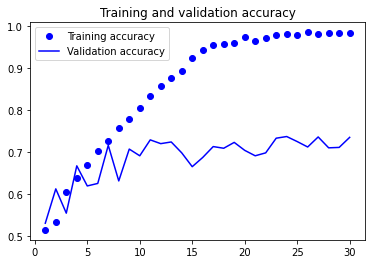

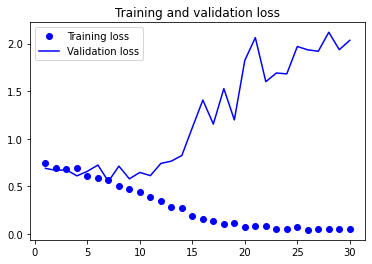

In [17]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [18]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 47ms/step - loss: 0.5825 - accuracy: 0.6870
Test accuracy: 0.687


After running the above model, we can make a few deductions:

1. The model is training very very well on the training set, to a paoint where it is overfitting.

2. The validation and test accuracy are not at all improving.

So in order to improve our validation andtest accuracy and prevent overfitting, we can use 3 techniques : 

a) Data Augmentation

b) Regularization

c) Dropout

Now we will use Data Augmentation to reduce the effects of Overfitting.

### Using Data Augmentation and Dropout

Data Augmentation works on a condition know as spatial invariance. This means that the object will be same irrespective of it's spatial location. For instance the number 1 will be the same whether that number appears in the top left corner, center or bottom right corner. 

So what exactly do we do in Data Augmentation?

In the simplest sense, we tend to flip, rotate, scale, crop, translate ( moving image along x and y axis), Gaussian Noise (way of distorting high-frequesncy by adding some noise to them).

For our Neural Network, we will only use flipping, rotation and zooming.

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Define a data augmentation stage to add to an image model**

In [19]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

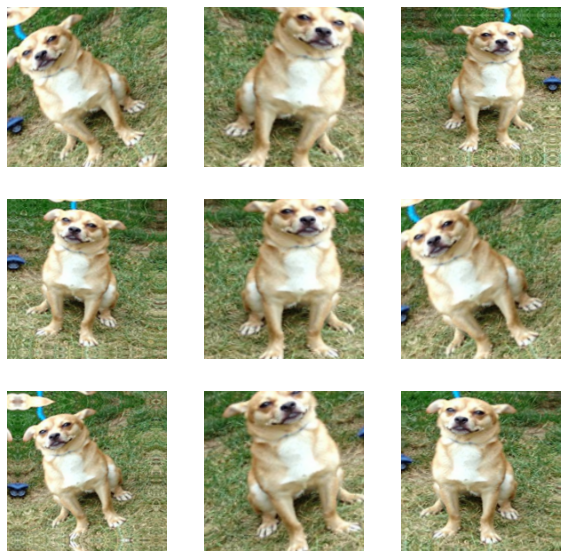

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Here we are showing a sample of 9 images that have been flipped, zoomed and rotated.

**Defining a new convnet that includes image augmentation and dropout**

In [21]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [22]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 9s 115ms/step - loss: 0.7193 - accuracy: 0.5050 - val_loss: 0.6927 - val_accuracy: 0.5100
Epoch 2/50
63/63 [==============================] - 7s 110ms/step - loss: 0.7025 - accuracy: 0.5305 - val_loss: 0.6758 - val_accuracy: 0.5930
Epoch 3/50
63/63 [==============================] - 7s 110ms/step - loss: 0.6805 - accuracy: 0.5840 - val_loss: 0.6460 - val_accuracy: 0.6290
Epoch 4/50
63/63 [==============================] - 7s 110ms/step - loss: 0.6725 - accuracy: 0.6240 - val_loss: 0.6427 - val_accuracy: 0.6010
Epoch 5/50
63/63 [==============================] - 7s 110ms/step - loss: 0.6469 - accuracy: 0.6460 - val_loss: 0.6531 - val_accuracy: 0.6250
Epoch 6/50
63/63 [==============================] - 7s 110ms/step - loss: 0.6428 - accuracy: 0.6420 - val_loss: 0.6824 - val_accuracy: 0.6220
Epoch 7/50
63/63 [==============================] - 7s 110ms/step - loss: 0.6031 - accuracy: 0.6820 - val_loss: 0.7046 - val_accuracy: 0.6350
Epoch 

How we are going to train our model again, this time by using data augmentation and dropout as well. 
Since we are using 2 out of 3 techniques for reducing over fitting, we are going to train it for a little longer as it is gonna take a while for our model to converge.

Here we have also used dropout. Dropout is nothing but ignoring or "dropping out" some of the layers. We basicaly turn off some of the layers during our training. 

Note: We can **only** use dropout for training set, not for the validation and test set.

This gives the effect of making a layer look-like and be treated-like a layer with different number of nodes and connectivity to the prior layers.

**Evaluating the model on the test set**

In [23]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 50ms/step - loss: 0.4578 - accuracy: 0.8030
Test accuracy: 0.803


As we can see that our test accuracy has already moved up just by using data augmentation and dropout. However we do have to train the model for more epochs than usual.

Hense we can say that by using Data Augmentation, dropout and Regularization we can some what mittigate the effects of Overfitting. 

**2. Increase your training sample size. You may pick any amount. Keep the validation and test 
samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?** 

**Copying images to training, validation, and test directories**

In [28]:
import os, shutil, pathlib

original_dir_2 = pathlib.Path("train")
new_base_dir_2 = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train_2", start_index=0, end_index=2000)
make_subset("validation_2", start_index=2000, end_index=2500)
make_subset("test_2", start_index=2500, end_index=3000)

Now in this question, we are going to increase our training sampe size to 2000, keeping validation and test same as before.

### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [29]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [30]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 41, 41, 128)       7385

**Configuring the model for training**

In [32]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

### Data preprocessing

**Using `image_dataset_from_directory` to read images**

In [33]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train_2",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation_2",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test_2",
    image_size=(180, 180),
    batch_size=32)

Found 4000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [34]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [35]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [36]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [37]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [38]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a `Dataset`**

In [39]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_updated_train_size.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
125/125 [==============================] - 13s 92ms/step - loss: 0.6935 - accuracy: 0.5228 - val_loss: 0.6744 - val_accuracy: 0.5270
Epoch 2/30
125/125 [==============================] - 12s 90ms/step - loss: 0.6662 - accuracy: 0.5962 - val_loss: 0.6489 - val_accuracy: 0.6290
Epoch 3/30
125/125 [==============================] - 12s 90ms/step - loss: 0.6257 - accuracy: 0.6497 - val_loss: 0.6185 - val_accuracy: 0.6790
Epoch 4/30
125/125 [==============================] - 12s 90ms/step - loss: 0.5957 - accuracy: 0.6805 - val_loss: 0.6138 - val_accuracy: 0.6720
Epoch 5/30
125/125 [==============================] - 12s 90ms/step - loss: 0.5571 - accuracy: 0.7110 - val_loss: 0.5666 - val_accuracy: 0.7060
Epoch 6/30
125/125 [==============================] - 12s 90ms/step - loss: 0.4959 - accuracy: 0.7535 - val_loss: 0.5708 - val_accuracy: 0.7280
Epoch 7/30
125/125 [==============================] - 12s 90ms/step - loss: 0.4586 - accuracy: 0.7775 - val_loss: 0.5130 - val_accuracy:

**Displaying curves of loss and accuracy during training**

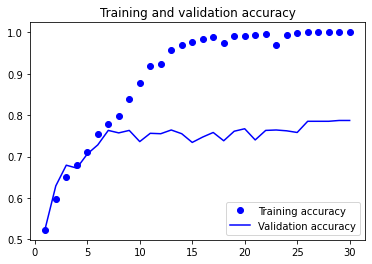

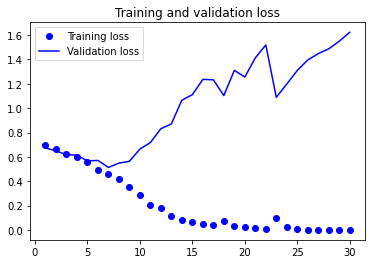

In [40]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [41]:
test_model = keras.models.load_model("convnet_from_scratch_updated_train_size.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 49ms/step - loss: 0.5989 - accuracy: 0.7230
Test accuracy: 0.723


As we can see above that we were able to achieve the accuracy of 100% for the training set, but the model didn't perfromed that well for validation and test set.

Now we will use Data Augmentation and Dropout to optimize this network and then look at the acuracies again.

### Using data augmentation and Dropout



**Define a data augmentation stage to add to an image model**

In [42]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

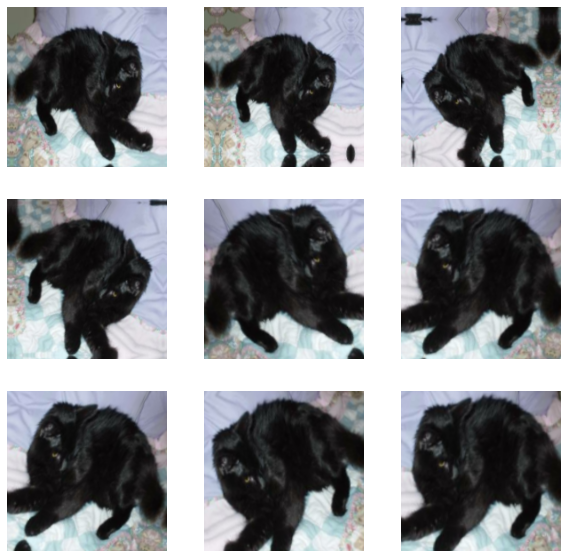

In [43]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Here we are showing a sample of 9 images that have been flipped, zoomed and rotated.

**Defining a new convnet that includes image augmentation and dropout**

In [45]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

**Training the regularized convnet**

In [46]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_updated_train_size_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/25
125/125 [==============================] - 14s 98ms/step - loss: 0.6940 - accuracy: 0.5110 - val_loss: 0.6905 - val_accuracy: 0.5000
Epoch 2/25
125/125 [==============================] - 12s 97ms/step - loss: 0.6803 - accuracy: 0.5642 - val_loss: 0.6694 - val_accuracy: 0.5790
Epoch 3/25
125/125 [==============================] - 12s 96ms/step - loss: 0.6678 - accuracy: 0.6050 - val_loss: 0.6449 - val_accuracy: 0.6170
Epoch 4/25
125/125 [==============================] - 12s 96ms/step - loss: 0.6569 - accuracy: 0.6223 - val_loss: 0.6279 - val_accuracy: 0.6470
Epoch 5/25
125/125 [==============================] - 12s 95ms/step - loss: 0.6243 - accuracy: 0.6475 - val_loss: 0.6015 - val_accuracy: 0.6700
Epoch 6/25
125/125 [==============================] - 12s 95ms/step - loss: 0.6069 - accuracy: 0.6812 - val_loss: 0.5600 - val_accuracy: 0.7140
Epoch 7/25
125/125 [==============================] - 12s 95ms/step - loss: 0.5818 - accuracy: 0.6902 - val_loss: 0.5476 - val_accuracy:

Here we can see alot of improvement already. First of all, our model is converging at a realy good rate; neither too fast nor too slow.
Secondly, train and validation accuracy are moving at almost similar rates.

**Evaluating the model on the test set**

In [47]:
test_model = keras.models.load_model(
    "convnet_from_scratch_updated_train_size_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 49ms/step - loss: 0.4207 - accuracy: 0.8140
Test accuracy: 0.814


Another big improvement that we can see is in the testing accuracy.

**3. Now change your training sample so that you achieve better performance than those from Steps 
1 and 2. This sample size may be larger, or smaller than those in the previous steps. The 
objective is to find the ideal training sample size to get best prediction results.**

**Copying images to training, validation, and test directories**

In [48]:
import os, shutil, pathlib

original_dir_3 = pathlib.Path("train")
new_base_dir_3 = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train_3", start_index=0, end_index=2500)
make_subset("validation_3", start_index=2500, end_index=3000)
make_subset("test_3", start_index=3000, end_index=3500)

### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [49]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [50]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 41, 41, 128)       7385

**Configuring the model for training**

In [51]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

### Data preprocessing

**Using `image_dataset_from_directory` to read images**

In [52]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train_3",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation_3",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test_3",
    image_size=(180, 180),
    batch_size=32)

Found 5000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [53]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [54]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [55]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [56]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [57]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a `Dataset`**

In [58]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_final.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
157/157 [==============================] - 15s 91ms/step - loss: 0.6890 - accuracy: 0.5246 - val_loss: 0.6742 - val_accuracy: 0.5610
Epoch 2/30
157/157 [==============================] - 14s 87ms/step - loss: 0.6681 - accuracy: 0.5692 - val_loss: 0.6813 - val_accuracy: 0.5360
Epoch 3/30
157/157 [==============================] - 14s 87ms/step - loss: 0.6547 - accuracy: 0.5974 - val_loss: 0.6834 - val_accuracy: 0.5670
Epoch 4/30
157/157 [==============================] - 14s 87ms/step - loss: 0.6217 - accuracy: 0.6506 - val_loss: 0.6611 - val_accuracy: 0.6380
Epoch 5/30
157/157 [==============================] - 14s 87ms/step - loss: 0.5659 - accuracy: 0.7078 - val_loss: 0.5953 - val_accuracy: 0.6830
Epoch 6/30
157/157 [==============================] - 14s 87ms/step - loss: 0.5317 - accuracy: 0.7338 - val_loss: 0.5599 - val_accuracy: 0.7010
Epoch 7/30
157/157 [==============================] - 14s 87ms/step - loss: 0.4843 - accuracy: 0.7676 - val_loss: 0.5676 - val_accuracy:

**Displaying curves of loss and accuracy during training**

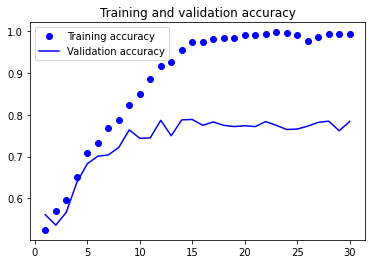

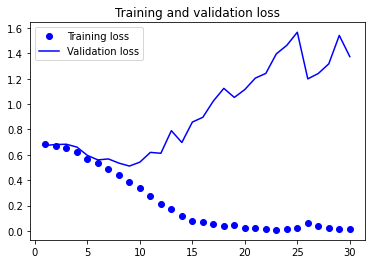

In [59]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [60]:
test_model = keras.models.load_model("convnet_from_scratch_final.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 49ms/step - loss: 0.4747 - accuracy: 0.7770
Test accuracy: 0.777


### Using data augmentation and Dropout



**Define a data augmentation stage to add to an image model**

In [61]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

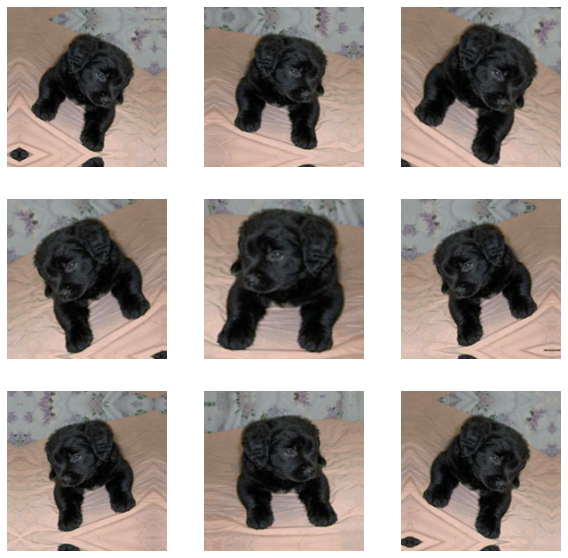

In [62]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Here we are showing a sample of 9 images that have been flipped, zoomed and rotated.

**Defining a new convnet that includes image augmentation and dropout**

In [64]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

**Training the regularized convnet**

In [65]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_final_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=35,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/35
157/157 [==============================] - 17s 95ms/step - loss: 0.6888 - accuracy: 0.5394 - val_loss: 0.6829 - val_accuracy: 0.5340
Epoch 2/35
157/157 [==============================] - 15s 93ms/step - loss: 0.6608 - accuracy: 0.5928 - val_loss: 0.6670 - val_accuracy: 0.6050
Epoch 3/35
157/157 [==============================] - 15s 94ms/step - loss: 0.6346 - accuracy: 0.6446 - val_loss: 0.6407 - val_accuracy: 0.6520
Epoch 4/35
157/157 [==============================] - 15s 93ms/step - loss: 0.6220 - accuracy: 0.6518 - val_loss: 0.6168 - val_accuracy: 0.6650
Epoch 5/35
157/157 [==============================] - 15s 93ms/step - loss: 0.5829 - accuracy: 0.7040 - val_loss: 0.6145 - val_accuracy: 0.6890
Epoch 6/35
157/157 [==============================] - 15s 92ms/step - loss: 0.5598 - accuracy: 0.7170 - val_loss: 0.5515 - val_accuracy: 0.7360
Epoch 7/35
157/157 [==============================] - 15s 93ms/step - loss: 0.5508 - accuracy: 0.7178 - val_loss: 0.6128 - val_accuracy:

The above results show us that we have a pretty good model at our hand. The reason I say so is because that the training and validation accuracy is moving at similar pace and by increasing the number of epochs we can make our model converge.

**Evaluating the model on the test set**

In [66]:
test_model = keras.models.load_model(
    "convnet_from_scratch_final_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 49ms/step - loss: 0.2915 - accuracy: 0.8830
Test accuracy: 0.883


**4. Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 
for the pretrained network may be the same or different from those using the network where 
you trained from scratch. Again, use any and all optimization techniques to get best 
performance.**

## Using a pretrained model

Now we are going to use a pretrained model and see how long does it take to make that model converge to the same dataset and also see how we can further finetune it.

**Instantiating the VGG16 convolutional base**

In [67]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [68]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

By glancing at the summary, it is very clear that this is a pretty big model, with almost 14 Million plus parameters.

#### Fast feature extraction without data augmentation

**Extracting the VGG16 features and corresponding labels**

In [69]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [70]:
train_features.shape

(5000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [72]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
157/157 [==============================] - 2s 7ms/step - loss: 7.2937 - accuracy: 0.9526 - val_loss: 5.5666 - val_accuracy: 0.9740
Epoch 2/20
157/157 [==============================] - 1s 7ms/step - loss: 2.4484 - accuracy: 0.9810 - val_loss: 6.4382 - val_accuracy: 0.9660
Epoch 3/20
157/157 [==============================] - 1s 6ms/step - loss: 1.3473 - accuracy: 0.9894 - val_loss: 6.6902 - val_accuracy: 0.9720
Epoch 4/20
157/157 [==============================] - 1s 6ms/step - loss: 0.4576 - accuracy: 0.9956 - val_loss: 4.8511 - val_accuracy: 0.9740
Epoch 5/20
157/157 [==============================] - 1s 6ms/step - loss: 0.4199 - accuracy: 0.9954 - val_loss: 6.1406 - val_accuracy: 0.9650
Epoch 6/20
157/157 [==============================] - 1s 6ms/step - loss: 0.5913 - accuracy: 0.9942 - val_loss: 6.8119 - val_accuracy: 0.9670
Epoch 7/20
157/157 [==============================] - 1s 6ms/step - loss: 0.3677 - accuracy: 0.9960 - val_loss: 7.3257 - val_accuracy: 0.9670
Epoch 

**Plotting the results**

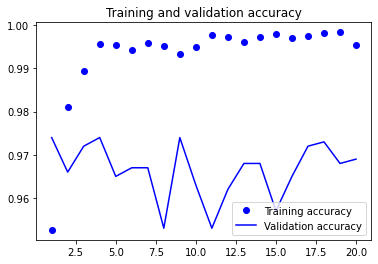

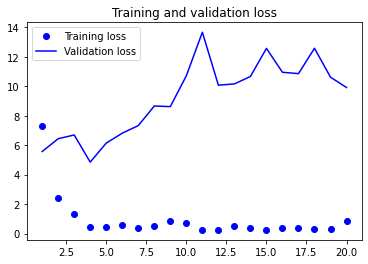

In [73]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

We can clearly see how well the pretrained model is working. The training and validation accuracy is moving at a similar pace and just by running for 20 epochs, we were able to get the accuracy of 98%.

#### Feature extraction together with data augmentation

Now we will use Data Augmentation on this network and see what results do we get.

**Instantiating and freezing the VGG16 convolutional base**

In [74]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [75]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [76]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [77]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [79]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
157/157 [==============================] - 38s 237ms/step - loss: 7.9680 - accuracy: 0.9430 - val_loss: 7.4994 - val_accuracy: 0.9520
Epoch 2/10
157/157 [==============================] - 37s 234ms/step - loss: 5.0154 - accuracy: 0.9582 - val_loss: 4.9867 - val_accuracy: 0.9680
Epoch 3/10
157/157 [==============================] - 37s 234ms/step - loss: 4.3006 - accuracy: 0.9574 - val_loss: 5.5946 - val_accuracy: 0.9630
Epoch 4/10
157/157 [==============================] - 37s 235ms/step - loss: 2.1393 - accuracy: 0.9714 - val_loss: 3.0894 - val_accuracy: 0.9650
Epoch 5/10
157/157 [==============================] - 37s 235ms/step - loss: 1.2740 - accuracy: 0.9770 - val_loss: 2.5295 - val_accuracy: 0.9720
Epoch 6/10
157/157 [==============================] - 37s 235ms/step - loss: 1.0692 - accuracy: 0.9738 - val_loss: 1.4136 - val_accuracy: 0.9740
Epoch 7/10
157/157 [==============================] - 37s 235ms/step - loss: 0.6935 - accuracy: 0.9744 - val_loss: 1.3495 - val_ac

**Evaluating the model on the test set**

In [80]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 7s 187ms/step - loss: 0.3824 - accuracy: 0.9850
Test accuracy: 0.985


We can see clearly that Data Augmentation wasn't able to improve our results significantly. 

So we will try some other technique. 

We will fine tune our model by freezing all the layers except for the last 4 and then check our model's accuracy.


### Fine-tuning a pretrained model

In [81]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

**Freezing all layers until the fourth from the last**

In [82]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Here we are freezing all the layers except for the first 2 layers, which are called the Convolution Base. Convolution Base are the nodes. The second part to this is the Classifier, which sits on the top of the convolution base.

**Fine-tuning the model**

In [83]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
157/157 [==============================] - 44s 267ms/step - loss: 0.2384 - accuracy: 0.9786 - val_loss: 0.6169 - val_accuracy: 0.9770
Epoch 2/10
157/157 [==============================] - 42s 266ms/step - loss: 0.2170 - accuracy: 0.9812 - val_loss: 0.5844 - val_accuracy: 0.9750
Epoch 3/10
157/157 [==============================] - 42s 265ms/step - loss: 0.1527 - accuracy: 0.9856 - val_loss: 0.6052 - val_accuracy: 0.9690
Epoch 4/10
157/157 [==============================] - 42s 265ms/step - loss: 0.1451 - accuracy: 0.9850 - val_loss: 0.5878 - val_accuracy: 0.9730
Epoch 5/10
157/157 [==============================] - 42s 268ms/step - loss: 0.0941 - accuracy: 0.9884 - val_loss: 0.4883 - val_accuracy: 0.9770
Epoch 6/10
157/157 [==============================] - 42s 269ms/step - loss: 0.0772 - accuracy: 0.9894 - val_loss: 0.4931 - val_accuracy: 0.9720
Epoch 7/10
157/157 [==============================] - 42s 268ms/step - loss: 0.0655 - accuracy: 0.9906 - val_loss: 0.4242 - val_ac

In [84]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 7s 192ms/step - loss: 0.2441 - accuracy: 0.9850
Test accuracy: 0.985


It is clear from the above that we were able to push our model a little further by freezing some of it's layers and retraining it on our dataset.

# Summary

## What is the relationship between training sample size and choice of network?  

I believe that training sample size and the choice of network plays a crucial role, but depending upon the settings in which we use them.

Like **Trainig Sample Size** plays a cruical role when you are training your own model from the scratch. A large enough trainig sample helps your model to converge better by picking up the signals. However, we might not need this in a **Pretrained Model**.

When it comes to **Pretrained Model**, we already have the weights for that model. All we need to do is run our data through it and get the desired result. But, there is a way to improve this as well. We can freeze some it's layers and train the model again with our data so that it can perform well on our data.

How this works is like this. By freezing some layers, we are keeping the weights of those layers intact. This saves us alot of time and computational power. If we were to train a similar model from the scratch, it would take alot of time, computational power and there is a good chance that it might not even converge for us. So by freezing some layers helps us skip that trouble entirely.

Now we can train the last few layers of the model as this will enable the model to grasp that special signals that might only be unique to our dataset. This will ultimately give us a model that works perfectly well for us on unseen data and we can even improve it later on by the above mentioned method.
